In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv
/kaggle/input/submission-merged3/submission_lightgbm.csv
/kaggle/input/submission-merged3/submission_catboost.csv
/kaggle/input/submission-merged3/submission_merged3.csv
/kaggle/input/submission-merged3/catboost_info/learn_error.tsv
/kaggle/input/submission-merged3/catboost_info/catboost_training.json
/kaggle/input/submission-merged3/catboost_info/time_left.tsv
/kaggle/input/submission-merged3/catboost_info/learn/events.out.tfevents


https://www.kaggle.com/udbhavpangotra/tps-apr21-eda-model


https://www.kaggle.com/hiro5299834/tps-apr-2021-voting-pseudo-labeling

# KAGGLE 스터디 

In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [3]:
TARGET = 'Survived'

N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [4]:
#랜덤 시드 생성
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

## 데이터 전처리

### lode data

In [5]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
#test_df['Survived'] = pd.read_csv("../input/submission-merged3/submission_merged3.csv")['Survived']

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
#reset_index : 인덱스를 세팅한다. drop=True를 하면 인덱스를 세팅한걸 삭제함. 


In [6]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (100000, 12)
Rows and Columns in test dataset: (100000, 11)


### 결측치 갯수 출력

In [7]:
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')
print()
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3292
SibSp: 0
Parch: 0
Ticket: 4623
Fare: 134
Cabin: 67866
Embarked: 250

Missing values per columns in test dataset
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3487
SibSp: 0
Parch: 0
Ticket: 5181
Fare: 133
Cabin: 70831
Embarked: 277


### Filling missing values

In [8]:
#나이는 나이의 평균치로 채운다.
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

#cabin은 문자열을 분할하고, 제일 첫번째 글자를 따와서 넣는다. 결측치엔 X를 넣는다.
#strip() : 양쪽 공백을 지운다. 여기서느 x[0]외엔 다 지우는듯. 
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())


#print(all_df['Ticket'].head(10))
#Ticket, fillna with 'X', split string and take first split 
#split() : 문자열 나누기. 디폴트는 ' '이고, 문자를 가진 데이터들이 전부 띄워쓰기로 구분되어있기때문에 가능. 
all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

#pclass에 따른 Fare의 평균을 구해서 dictionary형태로 만든다. 
fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
#fare의 결측치에 본인 행의 pclass 값을 넣고, 그 값을 fare 평균에 맵핑시킨다.  
all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
#유독 높은 가격이나 낮은 가격이 있기때문에, 이상치의 영향을 줄이기 위해서 Fare에 log를 취해준다.
all_df['Fare'] = np.log1p(all_df['Fare'])


#항구의 결측치를 X로 채운다. 
all_df['Embarked'] = all_df['Embarked'].fillna('X')

#이름은 성만 사용한다.
all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])


In [9]:
data_1=all_df.loc[all_df['Pclass']==1].groupby('Ticket')['Ticket'].count().sort_values(ascending=False)
print(data_1)
print()
data_2=all_df.loc[all_df['Pclass']==2].groupby('Ticket')['Ticket'].count().sort_values(ascending=False)
print(data_2)
print()
data_3=all_df.loc[all_df['Pclass']==3].groupby('Ticket')['Ticket'].count().sort_values(ascending=False)
print(data_3)
print()

Ticket
X             36336
PC            16814
C.A.            338
SC/Paris        334
SC/PARIS        260
W./C.           206
S.O.C.          192
S.C./PARIS      191
PP              186
F.C.            183
SC/AH           178
F.C.C.          167
STON/O          163
CA.             161
SOTON/O.Q.      123
A/4             115
A/5.            108
W.E.P.           94
WE/P             92
SOTON/OQ         87
STON/O2.         81
CA               81
A/5              70
C                67
A/4.             66
P/PP             66
SC               59
SOTON/O2         48
A./5.            46
S.O./P.P.        40
A.5.             33
AQ/4             27
A/S              23
SCO/W            19
S.P.             17
SC/A4            16
SW/PP            16
S.O.P.           15
SC/A.3           15
SO/C             14
S.C./A.4.        14
C.A./SOTON       14
A.               14
STON/OQ.         13
W/C              13
S.W./PP          11
LP               11
AQ/3.             8
Fa                7
A4.          

## 인코딩 

변수별로 인코딩을 다르게 해준다. 

In [10]:
label_cols = ['Name', 'Ticket', 'Sex','Pclass','Embarked']
onehot_cols = [ 'Cabin',]
numerical_cols = [ 'Age', 'SibSp', 'Parch', 'Fare']

In [11]:
#라벨 인코딩 함수. c라는 매개변수를 받아서 맞게 트렌스폼 해준다. 
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [12]:

#StandardScaler(): 평균을 제거하고 데이터를 단위 분산으로 조정한다. 
#그러나 이상치가 있다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 확산은 매우 달라지게 되는 함수
scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df,onehot_encoded_df, target_df], axis=1)
#all_df = pd.concat([numerical_df, label_encoded_df, target_df], axis=1)

## 모델링

In [13]:
drop_list=['Survived','Parch']

## not pseudo

In [14]:
train = all_df.iloc[:100000, :]#0개~100000개
test = all_df.iloc[100000:, :] #100000개~ 
#iloc은 정수형 인덱싱
test = test.drop('Survived', axis=1) #test에서 종속변수를 드랍한다. 
model_results = pd.DataFrame()
folds = 5

In [15]:
y= train.loc[:,'Survived']
X= train.drop(drop_list,axis=1)

## pseudo

In [16]:
# y=all_df.loc[:,'Survived']
# X=all_df.drop('Survived',axis=1)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)


In [18]:
from sklearn import metrics  
from sklearn.metrics import accuracy_score
import numpy as np

In [19]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [20]:
lgbm_model=lgb.LGBMClassifier(**params)
lgbm_model.fit(X_train,y_train)
lgbm_pred=lgbm_model.predict(X_valid)

lgbm_R2=metrics.accuracy_score(y_valid,lgbm_pred)
#lgbm_rmse = np.sqrt(mean_squared_error(lgbm_pred,y_valid))
print('R2 : ',lgbm_R2)
#print("RMSE : ", lgbm_rmse)

R2 :  0.78112


In [21]:
print(len(X_train.columns))
print(X_train.columns)

17
Index(['Age', 'SibSp', 'Fare', 'Name', 'Ticket', 'Sex', 'Pclass', 'Embarked',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')


In [22]:
def cal_adjust_r2(r2):
    n=80000
    k= len(X_train.columns)
    temp=(1-r2)*(n-1)
    temp2=n-k-1
    ad_r2=1-(temp/temp2)
    return ad_r2

In [23]:
ad_r2_lgbm=cal_adjust_r2(lgbm_R2)
print(ad_r2_lgbm)

0.7810734775324448


In [24]:
#NOT Pseudo
train_kf_feature=train.drop(drop_list,axis=1)
train_kf_label=train.loc[:,'Survived']

In [25]:
#Pseudo
# train_kf_feature=all_df.drop(drop_list,axis=1)
# train_kf_label=all_df.loc[:,'Survived']

In [26]:
n_iter=0
kfold=StratifiedKFold(n_splits=5)
cv_accuracy=[]
feature_importances = pd.DataFrame()

for train_idx, test_idx in kfold.split(train_kf_feature,train_kf_label):

    X_train=train_kf_feature.iloc[train_idx]
    X_test=train_kf_feature.iloc[test_idx]
    y_train,y_test=train_kf_label.iloc[train_idx],train_kf_label.iloc[test_idx]
    #학습 진행
    lgbm_model.fit(X_train,y_train)
    #예측
    fold_pred=lgbm_model.predict(X_test)
    
    #정확도
    n_iter+=1
    fold_accuracy=metrics.accuracy_score(y_test,fold_pred)
    print("\n {}번째  교차 검증 정확도 : {} , 학습 데이터 크기:{}, 검증 데이터 크기 :{} ".
          format(n_iter,fold_accuracy,X_train.shape[0],X_test.shape[0]))
    cv_accuracy.append(fold_accuracy)
    
    #중요도 
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = lgbm_model.feature_name_
    fi_tmp["importance"] = lgbm_model.feature_importances_
    feature_importances = feature_importances.append(fi_tmp)

print('\n 평균 검증 정확도 : ',np.mean(cv_accuracy))
    


 1번째  교차 검증 정확도 : 0.78045 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 

 2번째  교차 검증 정확도 : 0.7829 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 

 3번째  교차 검증 정확도 : 0.78255 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 

 4번째  교차 검증 정확도 : 0.7817 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 

 5번째  교차 검증 정확도 : 0.78145 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 

 평균 검증 정확도 :  0.7818099999999999


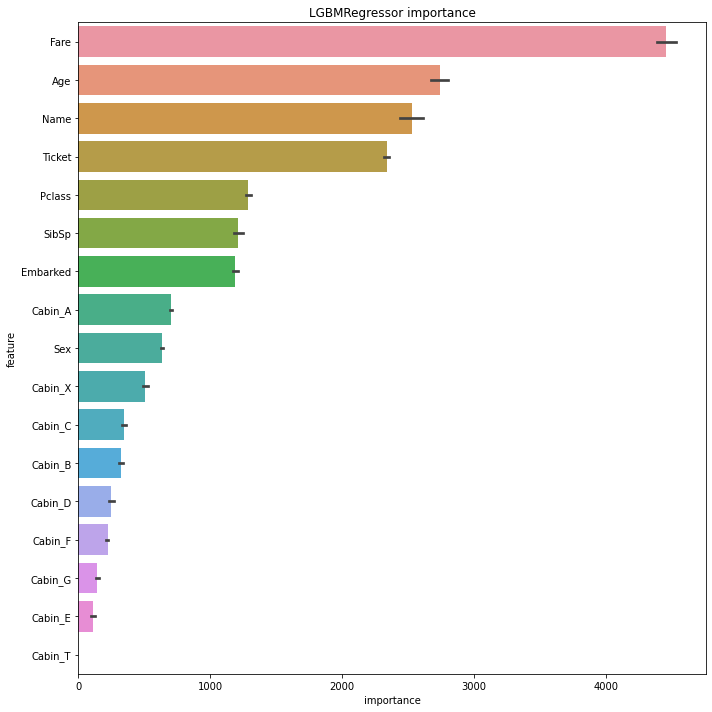

In [27]:
order = list(feature_importances.groupby("feature").
             mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

### CATBoost


In [28]:
params_cat = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [29]:
#새로운 트레인 valid 셋
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)


In [30]:

cat_model=ctb.CatBoostClassifier(**params_cat)
cat_model.fit(X_train, y_train,verbose=300)
cat_pred=cat_model.predict(X_valid)
print("\n정확도: ", metrics.accuracy_score(y_valid, cat_pred))
cat_R2=metrics.accuracy_score(y_valid,cat_pred)
#lgbm_rmse = np.sqrt(mean_squared_error(lgbm_pred,y_valid))
print('R2 : ',cat_R2)

0:	learn: 0.6881876	total: 21.6ms	remaining: 21.6s
300:	learn: 0.4671065	total: 3.61s	remaining: 8.39s
600:	learn: 0.4580581	total: 7.75s	remaining: 5.15s
900:	learn: 0.4513600	total: 11.6s	remaining: 1.28s
999:	learn: 0.4494353	total: 12.8s	remaining: 0us

정확도:  0.78088
R2 :  0.78088


In [31]:
cv_accuracy=[]
feature_importances = pd.DataFrame()

for train_idx, test_idx in kfold.split(train_kf_feature,train_kf_label):

    X_train=train_kf_feature.iloc[train_idx]
    X_test=train_kf_feature.iloc[test_idx]
    y_train,y_test=train_kf_label.iloc[train_idx],train_kf_label.iloc[test_idx]
    #학습 진행
    cat_model.fit(X_train,y_train,verbose=500)
    #예측
    fold_pred=cat_model.predict(X_test)
    
    #정확도
    n_iter+=1
    fold_accuracy=metrics.accuracy_score(y_test,fold_pred)
    print("\n {}번째  교차 검증 정확도 : {} , 학습 데이터 크기:{}, 검증 데이터 크기 :{} ".
          format(n_iter,fold_accuracy,X_train.shape[0],X_test.shape[0]))
    cv_accuracy.append(fold_accuracy)
    
    #중요도 . lgbm이랑 명령어가 다르다.
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = X_test.columns.to_list()
    fi_tmp["importance"] = cat_model.get_feature_importance()
    feature_importances = feature_importances.append(fi_tmp)

print('\n 평균 검증 정확도 : ',np.mean(cv_accuracy))

0:	learn: 0.6881429	total: 13ms	remaining: 13s
500:	learn: 0.4620239	total: 5.81s	remaining: 5.79s
999:	learn: 0.4511769	total: 12.1s	remaining: 0us

 6번째  교차 검증 정확도 : 0.779 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 
0:	learn: 0.6881913	total: 12.9ms	remaining: 12.9s
500:	learn: 0.4635385	total: 6.34s	remaining: 6.31s
999:	learn: 0.4528270	total: 13.2s	remaining: 0us

 7번째  교차 검증 정확도 : 0.78315 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 
0:	learn: 0.6881969	total: 12.8ms	remaining: 12.8s
500:	learn: 0.4636728	total: 6.19s	remaining: 6.17s
999:	learn: 0.4529596	total: 12.1s	remaining: 0us

 8번째  교차 검증 정확도 : 0.78255 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 
0:	learn: 0.6882583	total: 12.8ms	remaining: 12.8s
500:	learn: 0.4622361	total: 6.19s	remaining: 6.16s
999:	learn: 0.4513745	total: 12.5s	remaining: 0us

 9번째  교차 검증 정확도 : 0.78165 , 학습 데이터 크기:80000, 검증 데이터 크기 :20000 
0:	learn: 0.6882789	total: 13ms	remaining: 13s
500:	learn: 0.4630511	total: 6.65s	remaining: 6.62s
999:	learn: 0.4523127	total: 12.8s	rema

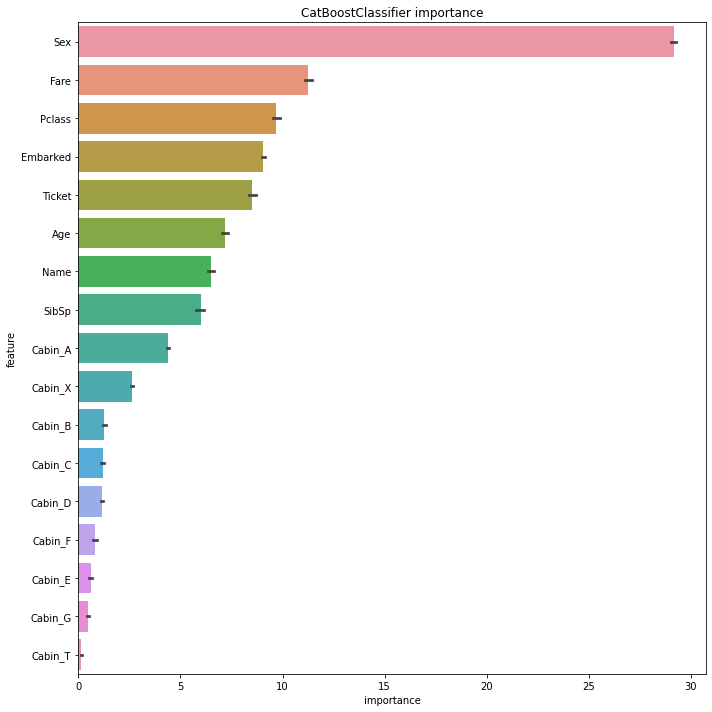

In [32]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

## Submission


In [33]:
def create_submission(model, test, test_passenger_id, model_name):
    y_pred_test = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame(
        {
            'PassengerId': test_passenger_id, 
            'Survived': (y_pred_test >= 0.5).astype(int),
        }
    )
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    
    return y_pred_test

In [34]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [35]:
#X_test=test.drop('Pclass',axis=1)
test = all_df.iloc[100000:, :] #100000개~ 
X_test=test.drop(drop_list,axis=1)
X_test.head()

,Age,SibSp,Fare,Name,Ticket,Sex,Pclass,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
100000,-0.937422,-0.539572,0.949786,10830,49,1,2,2,0,0,0,0,0,0,0,0,1
100001,1.123570,-0.539572,-1.273379,17134,49,0,2,2,0,0,0,0,0,0,0,0,1
100002,-0.937422,-0.539572,0.481059,9978,49,0,0,0,0,1,0,0,0,0,0,0,0
100003,-0.573717,-0.539572,-0.563310,13303,49,1,1,2,0,0,0,0,0,0,0,0,1
100004,-1.058657,-0.539572,0.125497,4406,49,0,0,0,0,1,0,0,0,0,0,0,0


In [36]:
test_pred_lightgbm = create_submission(
    lgbm_model, X_test, test_df["PassengerId"], "lightgbm"
)
test_pred_catboost = create_submission(
    cat_model, X_test, test_df["PassengerId"], "catboost"
)

In [37]:
test_pred_merged = (

    test_pred_lightgbm + 
    test_pred_catboost 
)
test_pred_merged = np.round(test_pred_merged / 2)

In [38]:
submission = pd.DataFrame(
    {
        'PassengerId': test_df["PassengerId"], 
        'Survived': test_pred_merged.astype(int),
    }
)
submission.to_csv(f"submission_merged3.csv", index=False)